# Text Mining Project - Guaitoli Carlo Alberto

## BBC Articles Text Clustering

The objective of this project is to perform a K-Means Clustering on BBC Articles. The articles are classified by human in 5 groups:
- Business
- Technology
- Entertainment
- Politics
- Sports

By performing the clustering we will evaluate how well the k-means algorithm works.

## Importing Packages and Data Loading and Transformation

#### Import Packages

In [5]:
# Essentials:
import pandas as pd
import numpy as np
from PIL import Image
import random
import warnings
# Text Mining Package:
import nltk
# Data Visualization Packages:
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.manifold import MDS
# Sklearn Packages (tools and metrics):
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Set a seed to replicate results:
random.seed(1000)
warnings.filterwarnings("ignore")
%matplotlib inline

#### Loading Articles
Create 5 lists containing the text of human-classified articles:

_Documents are classified in groups as described above_

In [6]:
for i in range(1,511):
    with open("/Users/carloalbertoguaitoli/bbc/business/ "+str(i)+".txt", "r") as f: 
        if i == 1:
            business_articles = [f.read()]
        else:
            business_articles.append(f.read())
for i in range(1,402):
    with open("/Users/carloalbertoguaitoli/bbc/tech/ "+str(i)+".txt", "r") as f: 
        if i == 1:
            tech_articles = [f.read()]
        else:
            tech_articles.append(f.read())
for i in range(1,387):
    with open("/Users/carloalbertoguaitoli/bbc/entertainment/ "+str(i)+".txt", "r") as f: 
        if i == 1:
            entertainment_articles = [f.read()]
        else:
            entertainment_articles.append(f.read())
for i in range(1,418):
    with open("/Users/carloalbertoguaitoli/bbc/politics/ "+str(i)+".txt", "r") as f: 
        if i == 1:
            politics_articles = [f.read()]
        else:
            politics_articles.append(f.read())
for i in range(1,508):
    with open("/Users/carloalbertoguaitoli/bbc/sport/ "+str(i)+".txt", "r") as f: 
        if i == 1:
            sport_articles = [f.read()]
        else:
            sport_articles.append(f.read())
print('\033[1m'+'\033[94m'+"In our document collection there are:"+'\033[0m')
print(len(business_articles),"articles that talks about business")
print(len(tech_articles),"articles that talks about technology")
print(len(entertainment_articles),"articles that talks about entertainment")
print(len(politics_articles),"articles that talks about politics")
print(len(sport_articles),"articles that talks about sport")

In our document collection there are:
510 articles that talks about business
401 articles that talks about technology
386 articles that talks about entertainment
417 articles that talks about politics
507 articles that talks about sport


#### Extract Titles form articles
It could be useful for sucessive analysis to identify them by using title:

In [7]:
business_articles_titles, tech_articles_titles,politics_articles_titles,sport_articles_titles,entertainment_articles_titles= [[],[],[],[],[]]
for i in range(0,len(business_articles)):
    business_articles_titles.append(business_articles[i].split("\n")[0])
for i in range(0,len(tech_articles)):
    tech_articles_titles.append(tech_articles[i].split("\n")[0])
for i in range(0,len(entertainment_articles)):
    entertainment_articles_titles.append(entertainment_articles[i].split("\n")[0])
for i in range(0,len(politics_articles)):
    politics_articles_titles.append(politics_articles[i].split("\n")[0])
for i in range(0,len(sport_articles)):
    sport_articles_titles.append(sport_articles[i].split("\n")[0])

#### Store Articles in a Pandas' DF
First, I convert the 5 lists in 5 pandas dataframe, one for each class. Then I merge them to obtain an unique dataframe with alla articles. I added a "Real Class" value to perform our "supervised" analysis.

In [8]:
df_business = pd.DataFrame({"Title":business_articles_titles,"Text":business_articles,"RealClass":"business_articles"})
df_sport = pd.DataFrame({"Title":sport_articles_titles,"Text":sport_articles,"RealClass":"sport"})
df_politics = pd.DataFrame({"Title":politics_articles_titles,"Text":politics_articles_titles,"RealClass":"politics"})
df_entertainment = pd.DataFrame({"Title":entertainment_articles_titles,"Text":entertainment_articles,"RealClass":"entertainment"})
df_tech = pd.DataFrame({"Title":tech_articles_titles,"Text":tech_articles,"RealClass":"tech_articles"})

In [9]:
documents = df_business.append(df_sport.append(df_politics.append(df_entertainment.append(df_tech))))
documents.head()

,Title,Text,RealClass
0,Ad sales boost Time Warner profit,Ad sales boost Time Warner profit\n\nQuarterly...,business_articles
1,Dollar gains on Greenspan speech,Dollar gains on Greenspan speech\n\nThe dollar...,business_articles
2,Yukos unit buyer faces loan claim,Yukos unit buyer faces loan claim\n\nThe owner...,business_articles
3,High fuel prices hit BA's profits,High fuel prices hit BA's profits\n\nBritish A...,business_articles
4,Pernod takeover talk lifts Domecq,Pernod takeover talk lifts Domecq\n\nShares in...,business_articles


## OT: Example of toketization and Pos Tagging

#### Example of toketization:
An example of toketization performed by nltk on the first article.

NB: _just printed the first 15_

In [12]:
tokens = nltk.word_tokenize(documents.iloc[0]["Text"])
tokens[:15]

['Ad',
 'sales',
 'boost',
 'Time',
 'Warner',
 'profit',
 'Quarterly',
 'profits',
 'at',
 'US',
 'media',
 'giant',
 'TimeWarner',
 'jumped',
 '76']

#### Example of Pos Tagging
NB: _just printed the first 10_

In [13]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Ad', 'NN'),
 ('sales', 'NNS'),
 ('boost', 'VBP'),
 ('Time', 'NNP'),
 ('Warner', 'NNP'),
 ('profit', 'VB'),
 ('Quarterly', 'JJ'),
 ('profits', 'NNS'),
 ('at', 'IN'),
 ('US', 'NNP')]

## Perform Text Clustering on my BBC's Articles
I perform a TF-IDF Transformation on my text that returns a term-document matrix. Then I perform a text clustering on articles (a flat clustering by using K-Means algorithm).
I'll obtain a fitted model that could classify articles in 5 categories.

NB: _it takes a while because the iteration will be 100 and the whole process is performed 10 times_

In [14]:
vectorizer = TfidfVectorizer(stop_words= text.ENGLISH_STOP_WORDS.union(["year"]))
X = vectorizer.fit_transform(documents["Text"])
model = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=10,random_state=100)
model.fit(X)
dist = 1 - cosine_similarity(X)

#### Visualization: WordCloud of most popular words in each cluster:

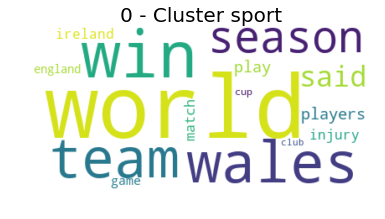

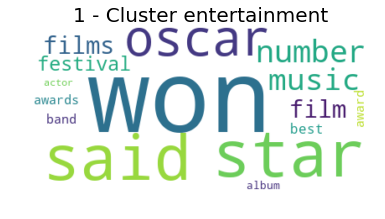

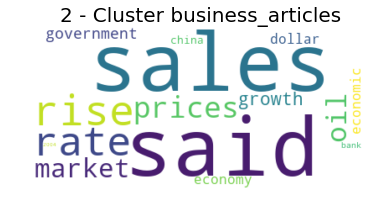

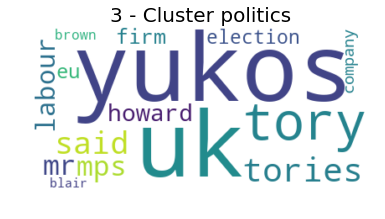

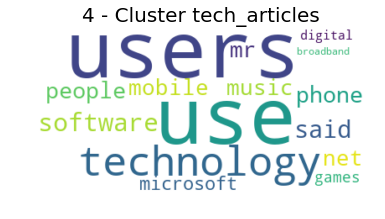

In [15]:
classes = ["sport","entertainment","business_articles","politics","tech_articles"]
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
vals = order_centroids
for i in range(5):
    d = {}
    for ind in order_centroids[i, :15]:
        d[str(terms[ind])] = ind
    wordcloud = WordCloud(background_color="white", max_words=15,contour_width=3, contour_color='firebrick')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(i)+' - Cluster '+classes[i],fontdict={"fontsize":20,"fontweight":10})
    plt.show()

## Prediction

#### Compute the predicted class for each article in DataFrame:
Using our fitted model to predict the articles:

In [16]:
pred_classes = []
num_class = []
for i in range(0,documents.shape[0]):
    prediction = model.predict(vectorizer.transform([documents.iloc[i]["Text"]]))
    if prediction == 0:
        pred_classes += ["sport"]
        num_class += [0]
    elif prediction == 1:
        pred_classes += ["entertainment"]
        num_class += [1]
    elif prediction == 2:
        pred_classes += ["business_articles"]
        num_class += [2]
    elif prediction == 3:
        pred_classes += ["politics"]
        num_class += [3]
    elif prediction == 4:
        pred_classes += ["tech_articles"]
        num_class += [4]

#### Add Predicted Class to DF to perform a supervised learning

In [17]:
documents["Predicted_Class"] = pred_classes
documents["Num_Class"] = num_class
documents.head()

,Title,Text,RealClass,Predicted_Class,Num_Class
0,Ad sales boost Time Warner profit,Ad sales boost Time Warner profit\n\nQuarterly...,business_articles,business_articles,2
1,Dollar gains on Greenspan speech,Dollar gains on Greenspan speech\n\nThe dollar...,business_articles,business_articles,2
2,Yukos unit buyer faces loan claim,Yukos unit buyer faces loan claim\n\nThe owner...,business_articles,politics,3
3,High fuel prices hit BA's profits,High fuel prices hit BA's profits\n\nBritish A...,business_articles,business_articles,2
4,Pernod takeover talk lifts Domecq,Pernod takeover talk lifts Domecq\n\nShares in...,business_articles,politics,3


## Result Evaluation:
I use a confusion matrix to assess how does the K-mean algorithm perform

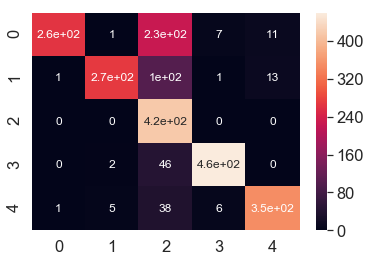

We just have a problem in prediction of class 2: Business


In [18]:
confusion_mat = confusion_matrix(documents["RealClass"], documents["Predicted_Class"])
confusion_mat_df = pd.DataFrame(confusion_mat, range(5),range(5))
sn.set(font_scale=1.5)
sn.heatmap(confusion_mat_df, annot=True, annot_kws={"size": 12})
plt.show()
print("We just have a problem in prediction of class 2: Business")

In [19]:
print("The Accuracy of Clustering is:",accuracy_score(documents["RealClass"], documents["Predicted_Class"]))
print("The Recall of Clustering is:", recall_score(documents["RealClass"], documents["Predicted_Class"],average='weighted'))
print("The F1 score of Clustering is:",f1_score(documents["RealClass"], documents["Predicted_Class"],average='weighted'))

The Accuracy of Clustering is: 0.7928860873480414
The Recall of Clustering is: 0.7928860873480414
The F1 score of Clustering is: 0.8004170827675178


## Data Visualization

#### Multidimensional Scaling
First, it transforms distances between objects in similarities. Then, it performs a PCA (with 2 components) to map it on 2-D space

NB: _it takes a while_ ~3min

In [20]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0],pos[:, 1]

#### Plot the results in 2-D Plot:

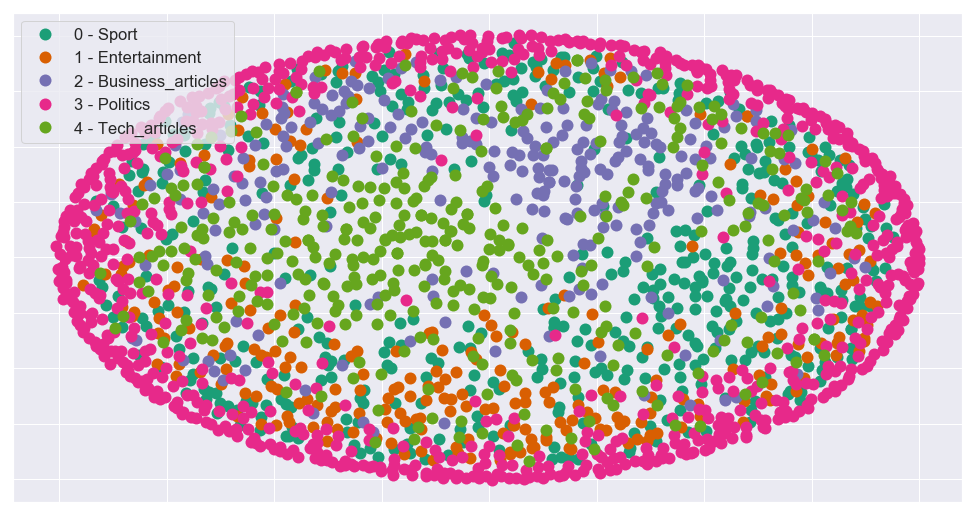

In [21]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_names = {0: '0 - Sport', 
                 1: '1 - Entertainment', 
                 2: '2 - Business_articles', 
                 3: '3 - Politics', 
                 4: '4 - Tech_articles'}
df = pd.DataFrame(dict(x=xs, y=ys, label=documents["Num_Class"], title=documents["Title"])) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         
        which='both',    
        bottom='off',     
        top='off',      
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',      
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
ax.legend(numpoints=1)
plt.show()